In [1]:
import datetime
import itertools
import sys

import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import (
    RESULTS_DIR,
    INDICATORS,
)
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.plot import backtest_plot
from finrl.plot import backtest_stats, get_baseline

D:\software\Anaconda3\envs\lab2\Lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
sys.path.append("../FinRL")

TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-31'

In [3]:
def process_data(processed):
    list_ticker = processed["tic"].unique().tolist()
    list_date = list(pd.date_range(processed['date'].min(), processed['date'].max()).astype(str))
    combination = list(itertools.product(list_date, list_ticker))

    processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(processed, on=["date", "tic"], how="left")
    processed_full = processed_full[processed_full['date'].isin(processed['date'])]
    processed_full = processed_full.sort_values(['date', 'tic'])

    processed_full = processed_full.fillna(0)
    return processed_full

In [4]:
processed = pd.read_csv('./datasets/processed.csv')
processed_full = process_data(processed)
train = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE, TRADE_END_DATE)
print(len(train))
print(len(trade))

83897
9744


In [5]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,2020-06-30,UNH,288.570007,296.450012,287.660004,284.978729,2932900.0,1.0,-0.019291,300.970812,268.613853,52.413042,-25.914882,1.846804,285.220263,278.269261,30.43,12.91881
2892,2020-06-30,V,191.490005,193.750000,190.160004,189.604050,9040100.0,1.0,1.042559,197.569689,183.942025,53.021046,-51.607981,2.013358,190.347372,180.598288,30.43,12.91881
2892,2020-06-30,VZ,54.919998,55.290001,54.360001,48.169018,17414800.0,1.0,-0.417954,51.555479,46.593793,48.097058,-51.186571,8.508886,48.776546,49.209270,30.43,12.91881
2892,2020-06-30,WBA,42.119999,42.580002,41.759998,38.128490,4782100.0,1.0,-0.082034,41.619007,35.639077,48.830195,-14.575578,1.500723,38.225630,38.030219,30.43,12.91881
2892,2020-06-30,WMT,119.220001,120.129997,118.540001,115.184013,6836400.0,1.0,-0.879410,118.508928,112.593776,48.159686,-69.964670,3.847272,116.836408,118.756424,30.43,12.91881


In [6]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.494560,110737200.0,2.0,3.000854,92.276534,79.814269,62.807155,107.499030,29.730532,83.550962,77.363088,28.620001,53.068185
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,236.683334,6575800.0,2.0,3.583841,229.038896,197.319536,61.279641,271.050724,46.806139,211.753600,212.811097,28.620001,53.068185
0,2020-07-01,AXP,95.250000,96.959999,93.639999,91.078461,3301000.0,2.0,-0.384904,109.215322,86.798777,48.504815,-66.306175,3.142448,96.180264,89.702835,28.620001,53.068185
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068185
0,2020-07-01,CAT,129.380005,129.399994,125.879997,118.455795,2807800.0,2.0,1.249468,128.246942,111.290112,52.865418,35.692967,14.457404,117.239540,111.578321,28.620001,53.068185


In [7]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [8]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [9]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [10]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

# set up logger
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_a2c.set_logger(new_logger_a2c)

trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=1000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c
--------------------------------------
| time/                 |            |
|    fps                | 147        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -0.0199    |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 39.6       |
|    reward             | -0.3891933 |
|    std                | 1          |
|    value_loss         | 1.91       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 142        |
|    iterations         | 200        |
|    time_elapsed       | 7          |
|    total_timesteps    | 1000       |
| train/                |            |
|    

In [11]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [12]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.494560,110737200.0,2.0,3.000854,92.276534,79.814269,62.807155,107.499030,29.730532,83.550962,77.363088,28.620001,53.068185
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,236.683334,6575800.0,2.0,3.583841,229.038896,197.319536,61.279641,271.050724,46.806139,211.753600,212.811097,28.620001,53.068185
0,2020-07-01,AXP,95.250000,96.959999,93.639999,91.078461,3301000.0,2.0,-0.384904,109.215322,86.798777,48.504815,-66.306175,3.142448,96.180264,89.702835,28.620001,53.068185
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068185
0,2020-07-01,CAT,129.380005,129.399994,125.879997,118.455795,2807800.0,2.0,1.249468,128.246942,111.290112,52.865418,35.692967,14.457404,117.239540,111.578321,28.620001,53.068185


In [13]:
trained_model = trained_a2c
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_model,
    environment = e_trade_gym)

hit end!


In [14]:
df_account_value.shape

(336, 2)

In [15]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.320909e+06
332,2021-10-25,1.327490e+06
333,2021-10-26,1.323389e+06
334,2021-10-27,1.312196e+06
335,2021-10-28,1.316852e+06


In [16]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0,37,16,30,47,0,0,0,0,0,...,0,24,0,0,0,35,39,0,0,46
2020-07-02,0,37,16,30,47,0,0,0,0,0,...,0,24,0,0,0,35,39,0,0,46
2020-07-06,0,37,16,30,47,0,0,0,0,0,...,0,24,0,0,0,35,39,0,0,46
2020-07-07,0,37,16,30,47,0,0,0,0,0,...,0,24,0,0,0,35,39,0,0,46
2020-07-08,0,37,16,30,47,0,0,0,0,0,...,0,24,0,0,0,35,39,0,0,46


In [17]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.229286
Cumulative returns     0.316852
Annual volatility      0.141961
Sharpe ratio           1.530003
Calmar ratio           2.651291
Stability              0.879557
Max drawdown          -0.086481
Omega ratio            1.290761
Sortino ratio          2.219997
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.104272
Daily value at risk   -0.017023
dtype: float64


In [18]:

print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])



stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


In [19]:
df_account_value.loc[0,'date']

'2020-07-01'

In [20]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

[*********************100%***********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,22.929%
Cumulative returns,31.685%
Annual volatility,14.196%
Sharpe ratio,1.53
Calmar ratio,2.65
Stability,0.88
Max drawdown,-8.648%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.65,2020-09-02,2020-10-30,2020-11-10,50
1,6.37,2021-05-07,2021-10-04,2021-10-22,121
2,3.93,2021-01-21,2021-01-29,2021-02-17,20
3,3.54,2020-07-22,2020-07-31,2020-08-10,14
4,3.31,2020-11-16,2020-11-20,2020-12-04,15


D:\software\Anaconda3\envs\lab2\Lib\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.09%,-3.46%,2.14%


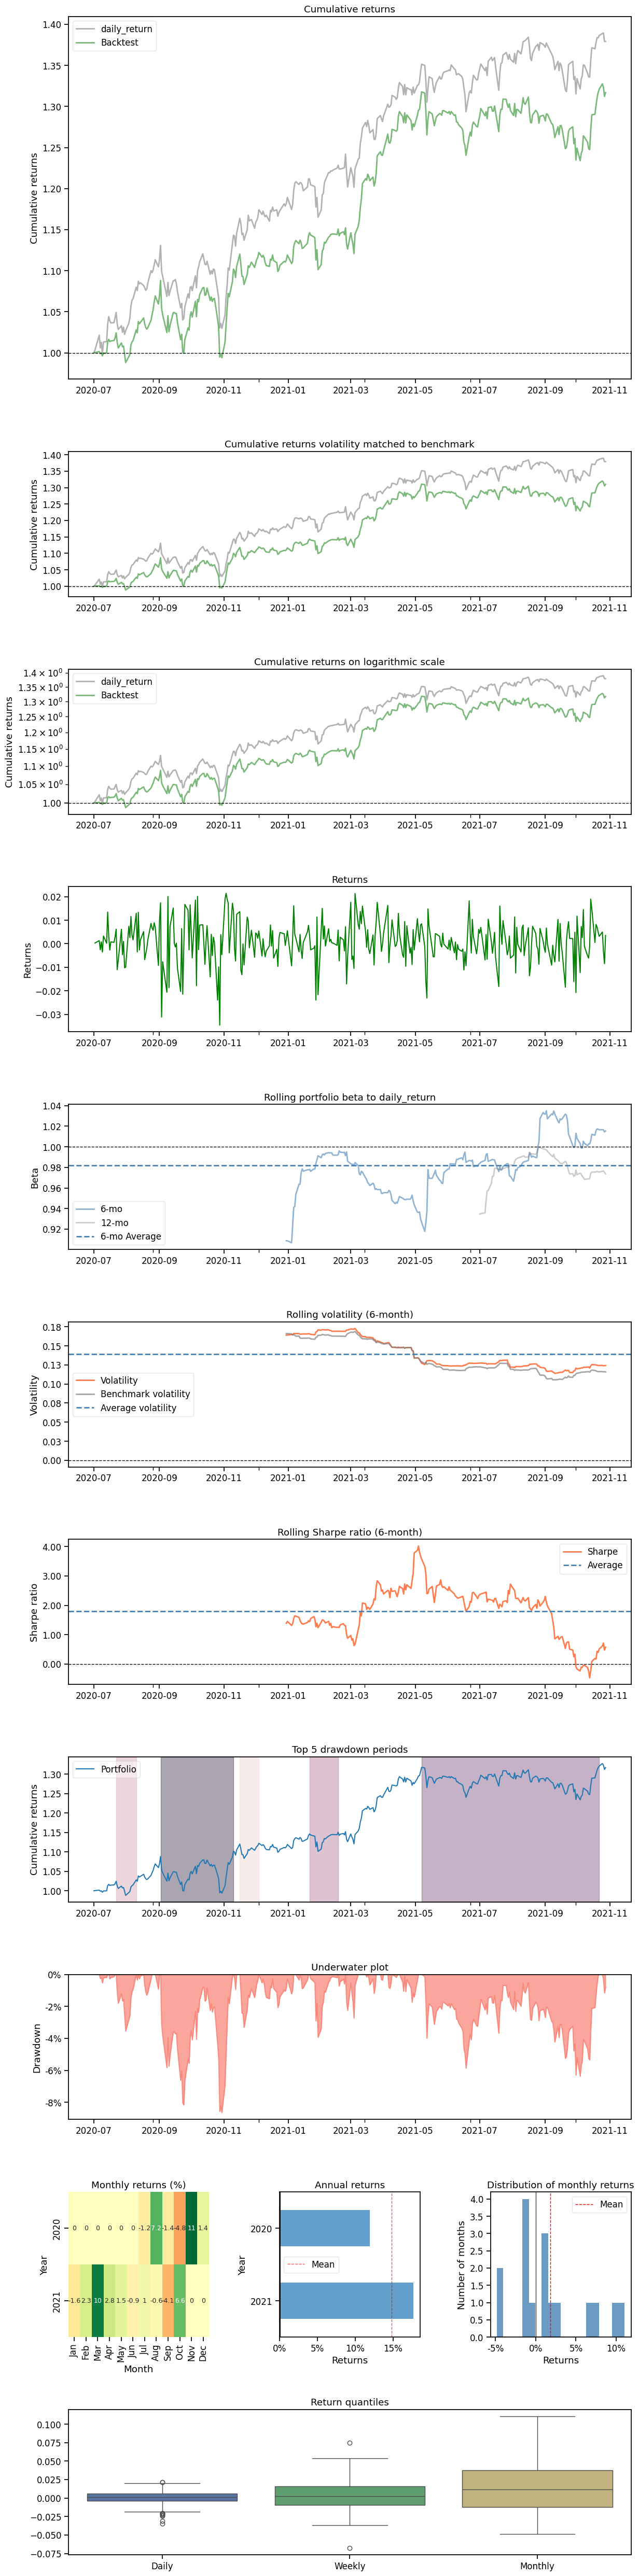

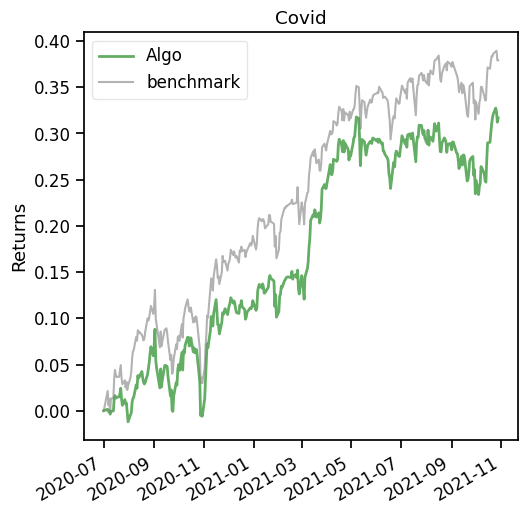

In [21]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value,
             baseline_ticker = '^DJI',
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])